# Imports and functions

In [90]:
import h5py
import matplotlib.colors as colors
import pandas as pd
import geopandas as gpd
import geopandas
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import argparse
from pathlib import Path
import cartopy.crs as ccrs

import matplotlib.cm as cm
import sys
import glob
import netCDF4
import os
import pyproj
import tqdm
import geopandas as gpd
from PIL import Image
import matplotlib.pyplot as plt
import odc.geo.xr
import shapely
from shapely.geometry import Point

In [3]:
def paths_to_datetimeindex(paths, string_slice=(0, 10), form='%Y%m'):
    """
    Helper function to generate a Pandas datetimeindex object
    from dates contained in a file path string.
    Parameters
    ----------
    paths : list of strings
        A list of file path strings that will be used to extract times
    string_slice : tuple
        An optional tuple giving the start and stop position that
        contains the time information in the provided paths. These are
        applied to the basename (i.e. file name) in each path, not the
        path itself. Defaults to (0, 10).
    Returns
    -------
    A pandas.DatetimeIndex object containing a 'datetime64[ns]' derived
    from the file paths provided by `paths`.
    """
    date_strings = [os.path.basename(i)[slice(*string_slice)]
                    for i in paths]
    return pd.to_datetime(date_strings, format=form)

In [64]:
## Function to read ATL10 data
def read_atl10(filename):
    # print('processing',filename)
    # Create a list for saving ATL10 beam track data
    track = []

    with h5py.File(filename,'r') as f:

        # Check the orbit orientation
        orient = f['orbit_info/sc_orient'][0]

        if orient == 0:
            strong_beams = [f"gt{i}l" for i in [1, 2, 3]]
        elif orient == 1:
            strong_beams = [f"gt{i}r" for i in [1, 2, 3]]
        else:
            strong_beams = []

        for beam in strong_beams[1:2]:
            if beam in f.keys():
                lat = f[beam]['freeboard_segment/latitude'][:]
                lon = f[beam]['freeboard_segment/longitude'][:]
                # Funky way to create a timestamp from the bytes
                time = pd.to_datetime(f['ancillary_data']['data_end_utc'][0][0:10].decode("utf-8"))
                seg_x = f[beam]['freeboard_segment/seg_dist_x'][:] / 1000 # (m to km)
                seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][:]
                fb = f[beam]['freeboard_segment/beam_fb_height'][:]
                surface_type = f[beam]['freeboard_segment/heights/height_segment_type'][:]
                fb[fb>100] = np.nan

                df = pd.DataFrame({'lat': lat, 'lon': lon, 'time':time, 'seg_x': seg_x, 'seg_len': seg_len,
                                  'freeboard': fb, 'stype': surface_type})

                df['beam'] = beam
                df = df.dropna().reset_index(drop = True)

                gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.lon, df.lat))

                # Assign crs information into geodatafraem
                gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
                
                if len(gdf) > 0:
                    track.append(gdf)
                    
    if len(track) > 0:
        track = pd.concat(track)
    else:
        track = pd.DataFrame()
            
    return track

# Create xarray / netcdf from h5 files

In [5]:
# Load and sort filelist by time

filedict = {}
# Path to IS2 H5 files
path = 'D:\\Floes\\ATL10'
print("Finding files")
# The "02" just matches the sea ice product
for file in Path(path).rglob('*ATL10-02*.h5'):
    time = pd.to_datetime(os.path.splitext(os.path.basename(file)[9:17])[0])
    filedict[time] = file
    
# The index numbers in the following line are used to sort the file list by date, they made need adjusting depending on which product you use.
# filelist = sorted(filelist, key=lambda i: int(os.path.splitext(os.path.basename(i)[9:17])[0]))
# print(f"Processing {len(filelist)} files")

# extract dimensions from top layer of h5 file
# dims = xr.open_dataset(filelist[0])

Finding files


In [21]:
months = {}

for date, data in filedict.items():
    yearmonth = date.strftime('%Y-%m')
    # print(yearmonth, data)
    # Update sum if already tracking, otherwise create new entry in dictionary
    # months[yearmonth] = data if yearmonth in months else total
    if yearmonth in months.keys():
        months[yearmonth].append(data)
    else:
        months[yearmonth] = [data]

# print(months)

## Every month

In [ ]:
for key, value in months.items():
    fb = []
    
    print("processing", key)
    # first = True
    # for file in value:
    #     df = read_atl10(file)
    #     if len(df) > 0:
    #         if first:
    #             one_month = df
    #             first = False
    #         else:
    #             one_month = pd.concat([one_month, df])
    one_month = pd.concat([read_atl10(file) for file in value])
    fb.append(one_month)
    
    # Define the figure and each axis
    fig, ax = plt.subplots(nrows=1,ncols=1,
                            subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude=-70)},
                           figsize = (7,7))

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    # axs=axs.flatten()

    #Loop over all of the models
    for i, month in enumerate(fb):
        # ax = axs[i]
        ax.set_facecolor('whitesmoke')
        ax.set_xlim([-3000000,0])
        ax.set_ylim([300000,3250000])
        month.to_crs("EPSG:3031").plot(marker='*', color='red', markersize=2, ax=ax)
        ax.coastlines()
        
    ax.annotate(f"{key}", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=15, ha='left', va='top', color = "k")
    plt.savefig(f"D:\\Floes\\figures\\Tracks_{key}.png", bbox_inches = "tight")
    plt.close()

In [61]:
one_month

,lat,lon,time,seg_x,seg_len,freeboard,stype,beam,geometry
0,-69.671870,-38.882061,2023-04-02,27842.484311,113.762451,0.080979,7,gt2l,POINT (-38.88206 -69.67187)
1,-69.672046,-38.882119,2023-04-02,27842.504093,70.563065,0.083086,7,gt2l,POINT (-38.88212 -69.67205)
2,-69.672163,-38.882158,2023-04-02,27842.517195,48.439163,0.078319,1,gt2l,POINT (-38.88216 -69.67216)
3,-69.672375,-38.882229,2023-04-02,27842.541006,39.130844,0.072192,1,gt2l,POINT (-38.88223 -69.67238)
4,-69.672467,-38.882261,2023-04-02,27842.551321,54.581070,0.079438,7,gt2l,POINT (-38.88226 -69.67247)
...,...,...,...,...,...,...,...,...,...
44097,-76.931044,-33.512214,2023-04-15,28660.934034,23.907610,0.129440,1,gt2l,POINT (-33.51221 -76.93104)
44098,-76.931131,-33.512278,2023-04-15,28660.943841,21.109417,0.121935,1,gt2l,POINT (-33.51228 -76.93113)
44099,-76.931223,-33.512347,2023-04-15,28660.954308,20.412125,0.111120,1,gt2l,POINT (-33.51235 -76.93122)
44100,-76.931314,-33.512415,2023-04-15,28660.964548,20.427128,0.115933,1,gt2l,POINT (-33.51241 -76.93131)


## Every three month

In [65]:
one_month

,lat,lon,time,seg_x,seg_len,freeboard,stype,beam,geometry
0,-69.671870,-38.882061,2023-04-02,27842.484311,113.762451,0.080979,7,gt2l,POINT (-38.88206 -69.67187)
1,-69.672046,-38.882119,2023-04-02,27842.504093,70.563065,0.083086,7,gt2l,POINT (-38.88212 -69.67205)
2,-69.672163,-38.882158,2023-04-02,27842.517195,48.439163,0.078319,1,gt2l,POINT (-38.88216 -69.67216)
3,-69.672375,-38.882229,2023-04-02,27842.541006,39.130844,0.072192,1,gt2l,POINT (-38.88223 -69.67238)
4,-69.672467,-38.882261,2023-04-02,27842.551321,54.581070,0.079438,7,gt2l,POINT (-38.88226 -69.67247)
...,...,...,...,...,...,...,...,...,...
44097,-76.931044,-33.512214,2023-04-15,28660.934034,23.907610,0.129440,1,gt2l,POINT (-33.51221 -76.93104)
44098,-76.931131,-33.512278,2023-04-15,28660.943841,21.109417,0.121935,1,gt2l,POINT (-33.51228 -76.93113)
44099,-76.931223,-33.512347,2023-04-15,28660.954308,20.412125,0.111120,1,gt2l,POINT (-33.51235 -76.93122)
44100,-76.931314,-33.512415,2023-04-15,28660.964548,20.427128,0.115933,1,gt2l,POINT (-33.51241 -76.93131)


In [69]:
read_atl10(value[0]).loc[:]

,lat,lon,time,seg_x,seg_len,freeboard,stype,beam,geometry
0,-69.671870,-38.882061,2023-04-02,27842.484311,113.762451,0.080979,7,gt2l,POINT (-38.88206 -69.67187)
1,-69.672046,-38.882119,2023-04-02,27842.504093,70.563065,0.083086,7,gt2l,POINT (-38.88212 -69.67205)
2,-69.672163,-38.882158,2023-04-02,27842.517195,48.439163,0.078319,1,gt2l,POINT (-38.88216 -69.67216)
3,-69.672375,-38.882229,2023-04-02,27842.541006,39.130844,0.072192,1,gt2l,POINT (-38.88223 -69.67238)
4,-69.672467,-38.882261,2023-04-02,27842.551321,54.581070,0.079438,7,gt2l,POINT (-38.88226 -69.67247)
...,...,...,...,...,...,...,...,...,...
43452,-77.650092,-43.168403,2023-04-02,28742.425602,20.503485,0.176483,1,gt2l,POINT (-43.16840 -77.65009)
43453,-77.650161,-43.168461,2023-04-02,28742.433477,18.386448,0.166642,1,gt2l,POINT (-43.16846 -77.65016)
43454,-77.650243,-43.168529,2023-04-02,28742.442807,19.801481,0.152029,1,gt2l,POINT (-43.16853 -77.65024)
43455,-77.650343,-43.168611,2023-04-02,28742.454094,22.640835,0.189416,1,gt2l,POINT (-43.16861 -77.65034)


In [81]:
list1 = ["a", "b" , "c"]
list2 = [1, 2, 3]

list3 = list1 + list2
print(list3)

['a', 'b', 'c', 1, 2, 3]


In [82]:
fb = []
for file in value[:4]:
    fb.append(read_atl10(file).loc[::3]) 

In [85]:
three_month = pd.concat(fb)

In [87]:
title = key
title += f"_{key}"

In [92]:
value[0]

WindowsPath('D:/Floes/ATL10/ATL10-02_20181014172058_02460101_006_02.h5')

In [95]:
for key, value in months.items():
    print("processing", key)  
    
    if key[-2:] in ["10", "01", "04", "07"]:
        fb = []
        first = True  
        title = key
    
    for file in value:
        fb.append(read_atl10(file).loc[::3])    
    
    if key[-2:] in ["12", "03", "06", "09"]:
        title += f"_{key}"
        three_month = pd.concat(fb)

        # Define the figure and each axis
        fig, ax = plt.subplots(nrows=1,ncols=1,
                               subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude=-70)},
                               figsize = (7,7))

        ax.set_facecolor('whitesmoke')
        ax.set_xlim([-3000000,0])
        ax.set_ylim([300000,3250000])
        three_month.to_crs("EPSG:3031").plot(marker='*', color='blue', markersize=2, ax=ax)
        ax.coastlines()

        ax.annotate(f"{title}", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=15, ha='left', va='top', color = "k")
        plt.savefig(f"D:\\Floes\\figures\\Tracks_3months_{title}.png", bbox_inches = "tight")
        plt.close()

processing 2018-10
processing 2018-11
processing 2018-12
processing 2019-01
processing 2019-02
processing 2019-03
processing 2019-04
processing 2019-05
processing 2019-06
processing 2019-07
processing 2019-08
processing 2019-09
processing 2019-10
processing 2019-11
processing 2019-12
processing 2020-01
processing 2020-02
processing 2020-03
processing 2020-04
processing 2020-05
processing 2020-06
processing 2020-07
processing 2020-08
processing 2020-09
processing 2020-10
processing 2020-11
processing 2020-12
processing 2021-01
processing 2021-02
processing 2021-03
processing 2021-04
processing 2021-05
processing 2021-06
processing 2021-07
processing 2021-08
processing 2021-09
processing 2021-10
processing 2021-11
processing 2021-12
processing 2022-01
processing 2022-02
processing 2022-03
processing 2022-04
processing 2022-05
processing 2022-06
processing 2022-07
processing 2022-08
processing 2022-09
processing 2022-10
processing 2022-11
processing 2022-12
processing 2023-01
processing 2

In [51]:
df = read_atl10(file)

processing D:\Floes\ATL10\ATL10-02_20181216135905_12060101_006_02.h5


In [52]:
df

[]

In [9]:
# We are only grabbing one month here and converting it to csv
# fb[1].to_csv("/g/data/jk72/sc0554/floes/beam_fb_height_young_data_201811.csv")

## Plotting

In [11]:
# Define the figure and each axis
fig, axs = plt.subplots(nrows=1,ncols=4,
                        subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude=-70)},
                       figsize = (10,10))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
# REPLACE SIMULATED DATA WITH FB IF HAS 12 months of data
for i, month in enumerate(simulated_data):
    if i in range(0,3):
        ax = axs[0]
        ax.set_facecolor('whitesmoke')
        ax.set_xlim([-3000000,0])
        ax.set_ylim([300000,3250000])
        month[month['beam']=='gt2r'].to_crs("EPSG:3031").plot(marker='*', color='#fd8d3c', markersize=3, ax=ax)
        ax.coastlines()
        ax.set_title('Jan-Feb-Mar')
    if i in range(3,6):
        ax = axs[1]
        ax.set_facecolor('whitesmoke')
        ax.set_xlim([-3000000,0])
        ax.set_ylim([300000,3250000])
        month[month['beam']=='gt2r'].to_crs("EPSG:3031").plot(marker='*', color='#fc4e2a', markersize=3, ax=ax)
        ax.coastlines()
        ax.set_title('Apr-May-Jun')
    if i in range(6,9):
        ax = axs[2]
        ax.set_facecolor('whitesmoke')
        ax.set_xlim([-3000000,0])
        ax.set_ylim([300000,3250000])
        month[month['beam']=='gt2r'].to_crs("EPSG:3031").plot(marker='*', color='#e31a1c', markersize=3, ax=ax)
        ax.coastlines()
        ax.set_title('Jul-Aug-Sep')
    if i in range(9,12):
        ax = axs[3]
        ax.set_facecolor('whitesmoke')
        ax.set_xlim([-3000000,0])
        ax.set_ylim([300000,3250000])
        month[month['beam']=='gt2r'].to_crs("EPSG:3031").plot(marker='*', color='#b10026', markersize=3, ax=ax)
        ax.coastlines()
        ax.set_title('Oct-Nov-Dec')


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x0000015374780C10> (for post_execute):
Error in callback <function flush_figures at 0x00000153051D25F0> (for post_execute):



KeyboardInterrupt


KeyboardInterrupt



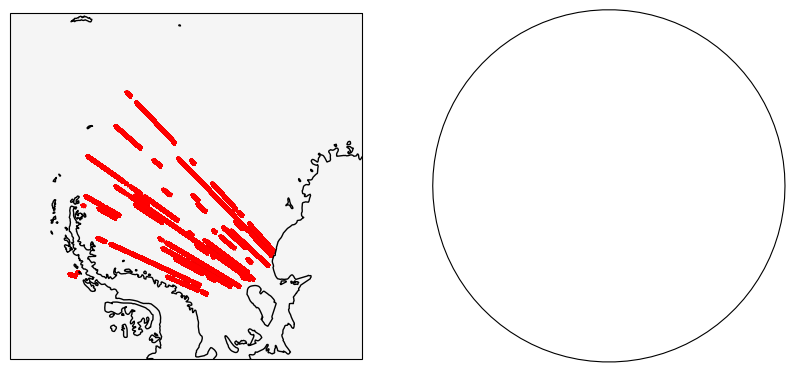

In [18]:
# Define the figure and each axis
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude=-70)},
                       figsize = (10,10))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for i, month in enumerate(fb):
    ax = axs[i]
    ax.set_facecolor('whitesmoke')
    ax.set_xlim([-3000000,0])
    ax.set_ylim([300000,3250000])
    month[month['beam']=='gt2r'].to_crs("EPSG:3031").plot(marker='*', color='red', markersize=3, ax=ax)
    ax.coastlines()
    
    

## Single plot

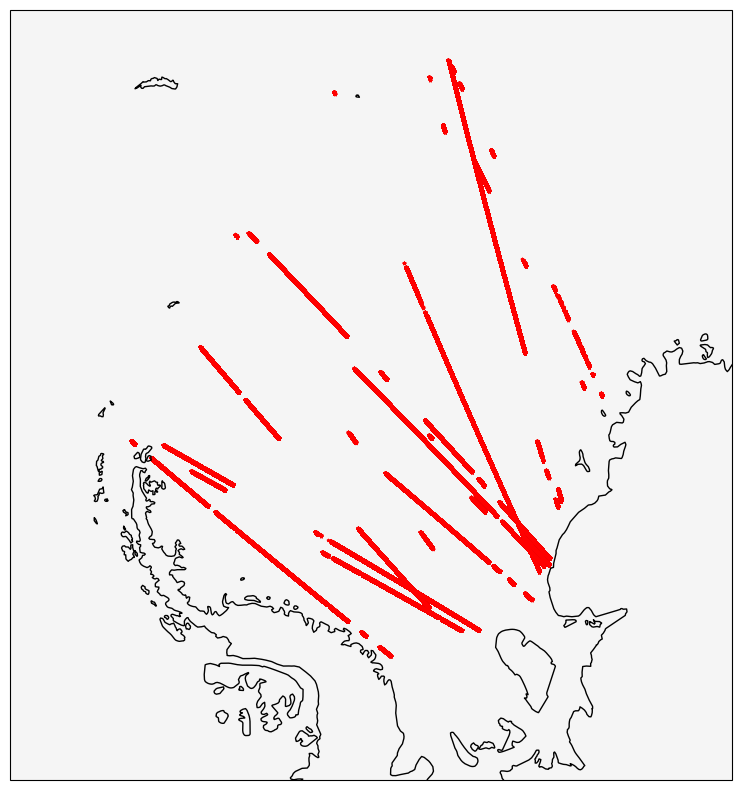

In [17]:
fig = plt.figure(figsize=(10,10))


ax=fig.add_subplot(projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))
ax.set_facecolor('whitesmoke')

ax.set_xlim([-3000000,0])
ax.set_ylim([300000,3500000])

fb[0][fb[0]['beam']=='gt2r'].to_crs("EPSG:3031").plot(marker='*', color='red', markersize=3, ax=ax)

# gl = ax.gridlines(
#     draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
#     xlocs=[-150,-120,-90,-60,-30,0,30,60,90,120,150,180], ylocs=[-50,-60,-70,-80]
# )

ax.coastlines()
# plt.savefig(f'/g/data/gv90/P6_data/report_card/report_card_{year}{month}.png',bbox_inches='tight')
plt.show()

## Scratch

/jobfs/105820541.gadi-pbs/ipykernel_3367325/2766593756.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


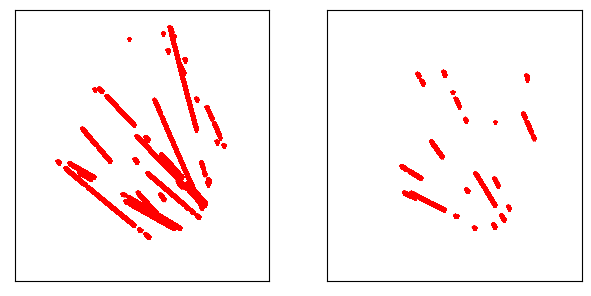

In [82]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_antarctic = world.to_crs('epsg:3031')
antarctica_3031 = world_antarctic[world_antarctic['name']=='Antarctica']
crs4326 = pyproj.CRS.from_epsg(4326)    # WGS84
crs3031 = pyproj.CRS.from_epsg(3031)    # Antarctic Polar Stereographic
transformer = pyproj.Transformer.from_crs(crs4326, crs3031, always_xy=True)

fig, ax = plt.subplots(1, 2)

plt.tight_layout()   
fig.tight_layout()

[axi.xaxis.set_visible(False) for axi in ax.ravel()]
[axi.yaxis.set_visible(False) for axi in ax.ravel()]

month = 0
for x in ax:
    x.set_xlim([-3000000,0])
    x.set_ylim([300000,3500000])
    # antarctica_3031.plot(ax=x, color='0.8', edgecolor='black')
    coastline.plot(ax=x, edgecolor='black')
    fb[month][fb[month]['beam']=='gt2r'].to_crs("EPSG:3031").plot(marker='*', color='red', markersize=3, ax=x)
    month+=1